In [25]:
pip install pandas nltk openpyxl

Note: you may need to restart the kernel to use updated packages.


In [35]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from collections import defaultdict
import re
import os

# Download required NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

def extract_sentiment_phrases(text, aspects, debug=False):
    """Extract sentiment-rich phrases related to specific aspects"""
    if not isinstance(text, str):
        if debug:
            print(f"Skipping non-string input: {text}")
        return {}
    
    if debug:
        print(f"Processing text: {text[:200]}...")  # Show first 200 chars for more context
    
    try:
        sentences = sent_tokenize(text.lower())
    except LookupError:
        print("Error: NLTK sentence tokenizer failed. Please ensure 'punkt_tab' is downloaded.")
        return {}
    
    if debug and not sentences:
        print("No sentences detected in text.")
    
    # Define sentiment keywords
    positive_words = {'great', 'good', 'excellent', 'amazing', 'wonderful', 'best', 'lovely', 
                     'perfect', 'friendly', 'clean', 'comfortable', 'helpful', 'nice', 'spacious', 'awesome'}
    negative_words = {'bad', 'terrible', 'poor', 'disappointing', 'rude', 'dirty', 'worst', 
                     'horrible', 'unfriendly', 'unhelpful', 'broken', 'overpriced', 'noisy', 'awful'}
    
    # Aspect keywords
    aspect_keywords = {
        'food': {'food', 'breakfast', 'restaurant', 'dining', 'buffet', 'meal', 'coffee', 'market'},
        'service': {'service', 'staff', 'desk', 'manager', 'employee', 'reception', 'check-in', 
                   'check-out', 'concierge', 'housekeeping', 'bellman'},
        'cleanliness': {'clean', 'dirty', 'maintained', 'housekeeping', 'spotless', 'dust', 'odor'},
        'attractions': {'location', 'attractions', 'times square', 'broadway', 'subway', 'walk'},
        'amenities': {'room', 'bed', 'bathroom', 'view', 'elevator', 'lobby', 'amenities', 'wifi', 
                     'parking', 'market', 'bar', 'gym', 'shower'}
    }
    
    results = defaultdict(list)
    
    for sentence in sentences:
        words = set(word_tokenize(sentence))
        sentiment = None
        if words & positive_words:
            sentiment = 'positive'
        elif words & negative_words:
            sentiment = 'negative'
            
        if sentiment:
            for aspect, keywords in aspect_keywords.items():
                if words & keywords:
                    results[aspect].append({
                        'text': sentence,
                        'sentiment': sentiment
                    })
                    if debug:
                        print(f"Found {sentiment} sentiment for {aspect}: {sentence}")
    
    if debug and not results:
        print("No sentiment phrases matched for this text.")
    
    return results

def process_reviews(df, text_column='text', debug=False):
    """Process all reviews and extract sentiment data"""
    all_results = []
    
    if text_column not in df.columns:
        print(f"Error: '{text_column}' column not found in DataFrame. Available columns: {list(df.columns)}")
        return pd.DataFrame()
    
    if debug:
        print(f"Processing {len(df)} reviews...")
    
    for index, row in df.iterrows():
        review_text = str(row[text_column])  # Convert to string to handle potential non-string inputs
        rating = row.get('rating', 'N/A')
        title = row.get('title', 'No Title')
        
        if not review_text or review_text.isspace():
            if debug:
                print(f"Empty or whitespace-only review at index {index}")
            continue
        
        sentiment_data = extract_sentiment_phrases(review_text, 
                                                 ['food', 'service', 'cleanliness', 
                                                  'attractions', 'amenities'], debug=debug)
        
        for aspect, phrases in sentiment_data.items():
            for phrase in phrases:
                all_results.append({
                    'review_title': title,
                    'rating': rating,
                    'aspect': aspect,
                    'text': phrase['text'],
                    'sentiment': phrase['sentiment'],
                    'original_index': index
                })
    
    return pd.DataFrame(all_results)

def save_to_excel(df, summary, output_file):
    """Save DataFrame and summary to Excel with error handling"""
    try:
        with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:  # Use xlsxwriter for better compatibility
            df.to_excel(writer, sheet_name='Sentiment_Details', index=False)
            summary.to_excel(writer, sheet_name='Sentiment_Summary', index=True)
        print(f"Successfully saved to '{output_file}'")
        
        # Validate the file
        if os.path.getsize(output_file) > 0:
            print(f"File '{output_file}' is not empty and contains data.")
        else:
            print(f"Warning: File '{output_file}' is empty despite saving attempt.")
    except Exception as e:
        print(f"Error saving to Excel: {str(e)}")
        # Attempt to save as CSV as a fallback
        csv_file = output_file.replace('.xlsx', '_fallback.csv')
        df.to_csv(csv_file, index=False)
        summary.to_csv(csv_file, mode='a', index=True)
        print(f"Fallback: Saved data to '{csv_file}' as CSV.")

def main():
    # Load the data from Excel
    input_file = "tripadvisor_reviews_scraped.xlsx"
    try:
        df = pd.read_excel(input_file)
        print(f"Loaded {len(df)} rows from '{input_file}'.")
        print(f"Columns found: {list(df.columns)}")
    except FileNotFoundError:
        print(f"Error: '{input_file}' not found in current directory.")
        return
    except Exception as e:
        print(f"Error loading Excel file: {str(e)}")
        return
    
    # Process reviews with debug mode on
    results_df = process_reviews(df, text_column='text', debug=True)
    
    if results_df.empty:
        print("No sentiment data extracted. This could be due to:")
        print("- 'text' column missing or empty reviews")
        print("- Sentiment keywords not matching review text")
        print("Check the debug output above for details.")
        # Save empty DataFrame with a note
        output_file = "tripadvisor_reviews_with_sentiment.xlsx"
        with pd.ExcelWriter(output_file) as writer:
            pd.DataFrame([{'note': 'No sentiment data extracted. Check input data and keywords.'}]).to_excel(writer, sheet_name='Notes', index=False)
        print(f"Created empty output file '{output_file}' with a note.")
        return
    
    # Merge original data with sentiment results
    original_cols = ['rating', 'text', 'title', 'publishedDate', 
                     'placeInfo/addressObj/city', 'placeInfo/addressObj/state',
                     'placeInfo/addressObj/country']
    available_cols = [col for col in original_cols if col in df.columns]
    merged_df = results_df.merge(
        df[available_cols],
        left_on=['review_title', 'rating'],
        right_on=['title', 'rating'],
        how='left'
    )
    
    # Drop redundant 'title' column if it exists
    if 'title' in merged_df.columns:
        merged_df = merged_df.drop(columns=['title'])
    
    # Reorder and rename columns
    column_order = ['original_index', 'review_title', 'rating', 'aspect', 'sentiment', 
                    'text_x', 'text_y', 'publishedDate', 'placeInfo/addressObj/city',
                    'placeInfo/addressObj/state', 'placeInfo/addressObj/country']
    merged_df = merged_df[[col for col in column_order if col in merged_df.columns]]
    merged_df = merged_df.rename(columns={'text_x': 'sentiment_phrase', 'text_y': 'full_review'})
    
    # Summary
    summary = results_df.groupby(['aspect', 'sentiment']).size().unstack(fill_value=0)
    print("\nSentiment Summary by Aspect:")
    print(summary)
    
    # Save to Excel with custom function
    output_file = "tripadvisor_reviews_with_sentiment.xlsx"
    save_to_excel(merged_df, summary, output_file)
    
    print("Sheet 'Sentiment_Details' contains detailed sentiment extractions")
    print("Sheet 'Sentiment_Summary' contains summary counts by aspect and sentiment")

if __name__ == "__main__":
    main()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chand\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\chand\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loaded 200 rows from 'tripadvisor_reviews_scraped.xlsx'.
Columns found: ['rating', 'text', 'title', 'publishedDate', 'travelDate', 'placeInfo/addressObj/city', 'placeInfo/addressObj/state', 'placeInfo/addressObj/country', 'placeInfo/locationString', 'subratings/0/name', 'subratings/0/value', 'subratings/1/name', 'subratings/1/value', 'subratings/2/name', 'subratings/2/value', 'subratings/3/name', 'subratings/3/value', 'subratings/4/name', 'subratings/4/value', 'subratings/5/name', 'subratings/5/value']
Processing 200 reviews...
Processing text: I arrived to find the room that I booked was sold out. Then I was informed that since a travel agency booked it they don’t guarantee the room that I booked and paid for.  I could have stayed in a numb...
No sentiment phrases matched for this text.
Processing text: This is the absolute BEST hotel in NYC in terms of comfort, convenience, safety, amenities and here's the best part: LOCATION!
    Last year, I stayed at the Hilton New York Times Squa

In [1]:

import pandas as pd




# Load the data into a DataFrame
df = pd.read_csv("tripadvisor_reviews_with_sentiment_fallback.csv")

# Display the first few rows and basic info
print("Initial DataFrame:")
print(df.head())
print("\nDataFrame Info:")
print(df.info())

Initial DataFrame:
  original_index                           review_title rating       aspect  \
0              1  Simply the BEST place to stay in NYC!      5  attractions   
1              1  Simply the BEST place to stay in NYC!      5  attractions   
2              1  Simply the BEST place to stay in NYC!      5    amenities   
3              1  Simply the BEST place to stay in NYC!      5    amenities   
4              2        Good choice for family vacation      4      service   

  sentiment                                   sentiment_phrase  \
0  positive  this is the absolute best hotel in nyc in term...   
1  positive  i loved the spacious guest rooms and its locat...   
2  positive  this is the absolute best hotel in nyc in term...   
3  positive  drawing inspiration from new york’s gilded age...   
4  positive  good location for family vacation, as we could...   

                                         full_review publishedDate  \
0  This is the absolute BEST hotel in N

In [18]:
df.isnull().sum()

original_index                  0
review_title                    0
rating                          0
aspect                          6
sentiment                       6
sentiment_phrase                6
full_review                     6
publisheddate                   6
placeinfo/addressobj/city       6
placeinfo/addressobj/state      6
placeinfo/addressobj/country    6
dtype: int64

In [14]:
df.head()

,original_index,review_title,rating,aspect,sentiment,sentiment_phrase,full_review,publisheddate,placeinfo/addressobj/city,placeinfo/addressobj/state,placeinfo/addressobj/country
0,1,Simply the BEST place to stay in NYC!,5,attractions,positive,this is the absolute best hotel in nyc in term...,This is the absolute BEST hotel in NYC in term...,2025-01-31,New York City,NY,United States
1,1,Simply the BEST place to stay in NYC!,5,attractions,positive,i loved the spacious guest rooms and its locat...,This is the absolute BEST hotel in NYC in term...,2025-01-31,New York City,NY,United States
2,1,Simply the BEST place to stay in NYC!,5,amenities,positive,this is the absolute best hotel in nyc in term...,This is the absolute BEST hotel in NYC in term...,2025-01-31,New York City,NY,United States
3,1,Simply the BEST place to stay in NYC!,5,amenities,positive,drawing inspiration from new york’s gilded age...,This is the absolute BEST hotel in NYC in term...,2025-01-31,New York City,NY,United States
4,2,Good choice for family vacation,4,service,positive,"good location for family vacation, as we could...","Good location for family vacation, as we could...",2025-04-24,New York City,NY,United States


In [16]:
df.dropna()

,original_index,review_title,rating,aspect,sentiment,sentiment_phrase,full_review,publisheddate,placeinfo/addressobj/city,placeinfo/addressobj/state,placeinfo/addressobj/country
0,1,Simply the BEST place to stay in NYC!,5,attractions,positive,this is the absolute best hotel in nyc in term...,This is the absolute BEST hotel in NYC in term...,2025-01-31,New York City,NY,United States
1,1,Simply the BEST place to stay in NYC!,5,attractions,positive,i loved the spacious guest rooms and its locat...,This is the absolute BEST hotel in NYC in term...,2025-01-31,New York City,NY,United States
2,1,Simply the BEST place to stay in NYC!,5,amenities,positive,this is the absolute best hotel in nyc in term...,This is the absolute BEST hotel in NYC in term...,2025-01-31,New York City,NY,United States
3,1,Simply the BEST place to stay in NYC!,5,amenities,positive,drawing inspiration from new york’s gilded age...,This is the absolute BEST hotel in NYC in term...,2025-01-31,New York City,NY,United States
4,2,Good choice for family vacation,4,service,positive,"good location for family vacation, as we could...","Good location for family vacation, as we could...",2025-04-24,New York City,NY,United States
...,...,...,...,...,...,...,...,...,...,...,...
408,195,Great spot for theater stay,4,amenities,positive,comfy bed excellent location for theater and s...,Comfy bed excellent location for theater and s...,2024-04-28,New York City,NY,United States
409,195,Great spot for theater stay,4,service,positive,some construction ongoing but staff was helpfu...,Comfy bed excellent location for theater and s...,2024-04-28,New York City,NY,United States
410,195,Great spot for theater stay,4,service,positive,bellman mike was particularly helpful in stori...,Comfy bed excellent location for theater and s...,2024-04-28,New York City,NY,United States
411,196,A very modern hotel in the middle of everything.,5,amenities,positive,the room was lovely modern and very clean.we h...,We stayed here for 2 nights. The room was love...,2024-04-27,New York City,NY,United States


In [20]:
df=df.drop(columns=["placeinfo/addressobj/city","placeinfo/addressobj/state"])

In [22]:
df

,original_index,review_title,rating,aspect,sentiment,sentiment_phrase,full_review,publisheddate,placeinfo/addressobj/country
0,1,Simply the BEST place to stay in NYC!,5,attractions,positive,this is the absolute best hotel in nyc in term...,This is the absolute BEST hotel in NYC in term...,2025-01-31,United States
1,1,Simply the BEST place to stay in NYC!,5,attractions,positive,i loved the spacious guest rooms and its locat...,This is the absolute BEST hotel in NYC in term...,2025-01-31,United States
2,1,Simply the BEST place to stay in NYC!,5,amenities,positive,this is the absolute best hotel in nyc in term...,This is the absolute BEST hotel in NYC in term...,2025-01-31,United States
3,1,Simply the BEST place to stay in NYC!,5,amenities,positive,drawing inspiration from new york’s gilded age...,This is the absolute BEST hotel in NYC in term...,2025-01-31,United States
4,2,Good choice for family vacation,4,service,positive,"good location for family vacation, as we could...","Good location for family vacation, as we could...",2025-04-24,United States
...,...,...,...,...,...,...,...,...,...
414,amenities,15,101,NaN,NaN,NaN,NaN,NaN,NaN
415,attractions,0,70,NaN,NaN,NaN,NaN,NaN,NaN
416,cleanliness,8,61,NaN,NaN,NaN,NaN,NaN,NaN
417,food,3,28,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# Handle missing values in essential fields
df.dropna(subset=['rating', 'full_review'], inplace=True)

# Remove duplicate full reviews
df.drop_duplicates(subset='full_review', inplace=True)

# Normalize ratings (e.g., if on scale 0–10)
# Convert rating to numeric (coerce errors to NaN)
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

# Drop rows where conversion failed (NaNs)
df.dropna(subset=['rating'], inplace=True)

# Normalize rating if needed
if df['rating'].max() > 5:
    df['rating'] = df['rating'] / 2

# Round and convert to integer
df['rating'] = df['rating'].round().astype(int)

# Convert publish date to datetime
df['publisheddate'] = pd.to_datetime(df['publisheddate'], errors='coerce')

# Standardize data types
df['sentiment'] = df['sentiment'].astype('category')
df['aspect'] = df['aspect'].astype('category')
df['rating'] = df['rating'].astype('int')

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 130 entries, 0 to 411
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   original_index                130 non-null    object        
 1   review_title                  130 non-null    object        
 2   rating                        130 non-null    int32         
 3   aspect                        130 non-null    category      
 4   sentiment                     130 non-null    category      
 5   sentiment_phrase              130 non-null    object        
 6   full_review                   130 non-null    object        
 7   publisheddate                 130 non-null    datetime64[ns]
 8   placeinfo/addressobj/country  130 non-null    object        
dtypes: category(2), datetime64[ns](1), int32(1), object(5)
memory usage: 8.2+ KB


In [30]:
df

,original_index,review_title,rating,aspect,sentiment,sentiment_phrase,full_review,publisheddate,placeinfo/addressobj/country
0,1,Simply the BEST place to stay in NYC!,5,attractions,positive,this is the absolute best hotel in nyc in term...,This is the absolute BEST hotel in NYC in term...,2025-01-31,United States
4,2,Good choice for family vacation,4,service,positive,"good location for family vacation, as we could...","Good location for family vacation, as we could...",2025-04-24,United States
8,3,Ver bad experience and poor service,2,amenities,negative,terrible experience for us...\ni have booked 6...,Terrible experience for us...\nI have booked 6...,2025-04-24,United States
9,4,Excellent Hotel and location.,5,cleanliness,positive,"the rooms were very spacious and modern, with ...",i recently spent three nights at the Hilton Ho...,2025-04-23,United States
11,7,"Avoid!! Long lines, unfriendly staff, dirty rooms",1,service,positive,chose hilton based on the “brand.“ we paid a p...,Really disappointing stay. Kids were on spring...,2025-04-17,United States
...,...,...,...,...,...,...,...,...,...
399,191,"Great experience, even with renovations going on",4,service,positive,we had a great stay at the hilton and want to ...,We had a great stay at the Hilton and want to ...,2024-05-05,United States
400,192,Great spot to lay my head,5,service,positive,"nice room in the heart of times square, attent...","Nice room in the heart of Times Square, attent...",2024-05-03,United States
402,194,"Pretty average really, good location, good vie...",3,service,positive,who knows..... most of the staff were genuinel...,"Mixed feelings, we got a reasonable price on t...",2024-04-29,United States
407,195,Great spot for theater stay,4,attractions,positive,comfy bed excellent location for theater and s...,Comfy bed excellent location for theater and s...,2024-04-28,United States


In [34]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer


# Download NLTK assets
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Setup preprocessing tools
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text.lower())
    
    # Remove non-alpha and stopwords
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    
    # Stemming and lemmatization
    stemmed = [stemmer.stem(word) for word in tokens]
    lemmatized = [lemmatizer.lemmatize(word) for word in stemmed]
    
    return ' '.join(lemmatized)

# Apply to review title and full review
df['cleaned_review_title'] = df['review_title'].apply(preprocess_text)
df['cleaned_full_review'] = df['full_review'].apply(preprocess_text)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chand\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chand\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [38]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Step 1: Drop rows with missing cleaned review or sentiment
df.dropna(subset=['full_review', 'sentiment'], inplace=True)

# Step 2: Encode target labels (e.g., positive/negative/neutral → 0/1/2)
label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['sentiment'])

# Step 3: Split data
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_full_review'], df['sentiment_encoded'], test_size=0.2, random_state=42
)

# Step 4: Vectorize text using TF-IDF
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

# Step 5: Train Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)

# Step 6: Predictions and Evaluation
y_pred = nb_model.predict(X_test_vec)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Accuracy: 0.9230769230769231

Classification Report:
               precision    recall  f1-score   support

    negative       0.00      0.00      0.00         2
    positive       0.92      1.00      0.96        24

    accuracy                           0.92        26
   macro avg       0.46      0.50      0.48        26
weighted avg       0.85      0.92      0.89        26



C:\Users\chand\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chand\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chand\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [36]:
df.columns

Index(['original_index', 'review_title', 'rating', 'aspect', 'sentiment',
       'sentiment_phrase', 'full_review', 'publisheddate',
       'placeinfo/addressobj/country', 'cleaned_review_title',
       'cleaned_full_review'],
      dtype='object')

In [40]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download VADER resources
nltk.download('vader_lexicon')

# Initialize VADER
vader = SentimentIntensityAnalyzer()

# Function to get sentiment category
def vader_sentiment_category(text):
    score = vader.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply to cleaned full reviews
df['vader_sentiment'] = df['full_review'].apply(vader_sentiment_category)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\chand\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [48]:
print(df[['sentiment', 'vader_sentiment']].head(10))

   sentiment vader_sentiment
0   positive        positive
4   positive        positive
8   negative        negative
9   positive        positive
11  positive        positive
16  positive        positive
18  positive        positive
20  positive        positive
25  positive        positive
32  positive        positive


In [50]:
import pandas as pd

# Group by aspect and sentiment
aspect_sentiment_counts = df.groupby(['aspect', 'sentiment']).size().reset_index(name='count')

# Pivot for visualization
aspect_pivot = aspect_sentiment_counts.pivot(index='aspect', columns='sentiment', values='count').fillna(0)

# Display the summary table
print(aspect_pivot)

sentiment    negative  positive
aspect                         
amenities           5        16
attractions         0        29
cleanliness         3        17
food                0         8
service            10        42


C:\Users\chand\AppData\Local\Temp\ipykernel_17860\3170889714.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aspect_sentiment_counts = df.groupby(['aspect', 'sentiment']).size().reset_index(name='count')


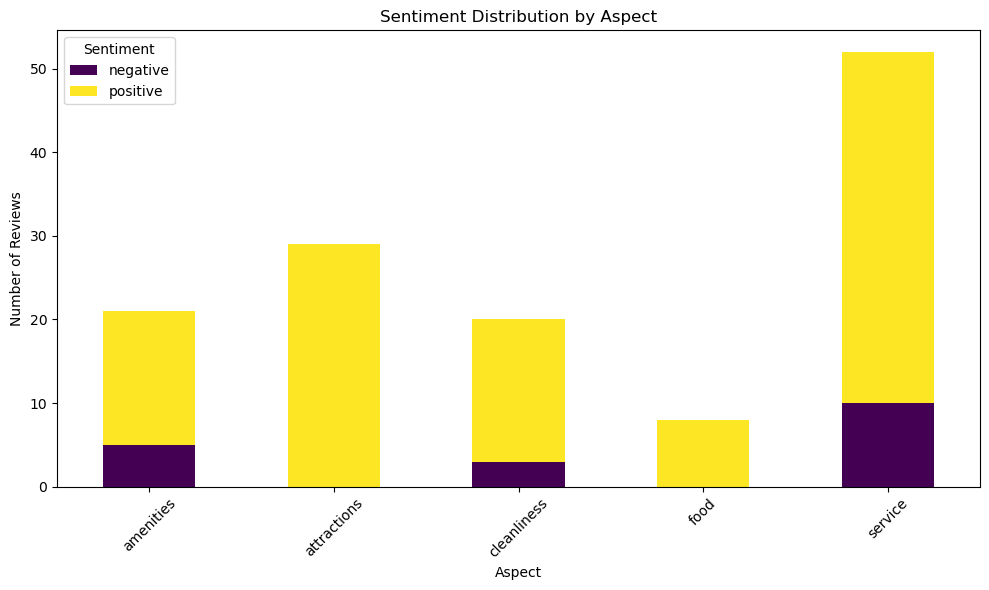

In [52]:
import matplotlib.pyplot as plt

# Plot stacked bar chart
aspect_pivot.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Sentiment Distribution by Aspect')
plt.xlabel('Aspect')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

In [54]:
# Aspects with the most negative mentions
most_negative = aspect_sentiment_counts[aspect_sentiment_counts['sentiment'] == 'negative']
most_negative = most_negative.sort_values(by='count', ascending=False)
print("Most complained-about aspects:")
print(most_negative.head())

# Aspects with most positive mentions
most_positive = aspect_sentiment_counts[aspect_sentiment_counts['sentiment'] == 'positive']
most_positive = most_positive.sort_values(by='count', ascending=False)
print("\nMost praised aspects:")
print(most_positive.head())

Most complained-about aspects:
        aspect sentiment  count
8      service  negative     10
0    amenities  negative      5
4  cleanliness  negative      3
2  attractions  negative      0
6         food  negative      0

Most praised aspects:
        aspect sentiment  count
9      service  positive     42
3  attractions  positive     29
5  cleanliness  positive     17
1    amenities  positive     16
7         food  positive      8
